In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         installation
###-------------------------------------------------------------------------------------------------------------------

!pip install imagecodecs
!pip install segmentation_models_pytorch
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2b2b427a5e575bb065442a9131a0a55d89103042f3c449dee1244bfdb0a98e55
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=14374c7c0c02face34b1959cccab82f8a2e231029b3e753cfa70d09ba6e79065
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

Task Monitoring changes in glacier extent and volume is essential for understanding climate change
impacts. In this project, we aim to spatially map glaciers (i.e. semantic segmentation) in Greenland and
do a temporal comparison using multi-temporal satellite imagery. Specifically, the goal of this project is
two-folded:

• At a fixed date, train a neural network for segmentation on a glacier area and evaluate it on
another one.

• Evaluate the neural network at a different date for temporal comparison


link to models : https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         imports
###-------------------------------------------------------------------------------------------------------------------
from google.colab import drive
import matplotlib.pyplot as plt
import os
import numpy as np
from imagecodecs import imread
from torch.utils.data import DataLoader, TensorDataset
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F
import torch.nn as nn
import logging
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split


In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         connecting google drive
###-------------------------------------------------------------------------------------------------------------------
drive.mount("/content/drive")

#!unzip /content/drive/MyDrive/glaciers_mapping.zip
!unzip drive/MyDrive/glaciers_mapping.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: glaciers_mapping_downsampled/train/date0/patch_6_41.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_21_25.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_23_43.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_2_18.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_19_66.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_21_33.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_19_2.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_8_38.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_11_67.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_10_21.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_22_35.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_18_45.tif  
  inflating: glaciers_mapping_downsampled/train/date0/patch_10

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         model and train hyperparameters
###-------------------------------------------------------------------------------------------------------------------

config = {
    # general
    "epochs": 5,
    "batch_size": 32,
    "lr": 1e-3,

    # model
    "d_model_input": 400,
    "d_model_intermediate": 512,
    "d_model_output": 8,
    "dropout" : 0.1,
    "attention_dropout" : 0.1,
    "num_heads": 4,
    "num_layers": 0 # TBA?
}

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#        loading images
###-------------------------------------------------------------------------------------------------------------------

image_list_train_date_0 = os.listdir(f"glaciers_mapping_downsampled/train/date0")
image_list_test_date_0 = os.listdir(f"glaciers_mapping_downsampled/test/date0")
image_list_train_date_1 = os.listdir(f"glaciers_mapping_downsampled/train/date1")
image_list_test_date_1 = os.listdir(f"glaciers_mapping_downsampled/test/date1")
ground_truth_list_train = os.listdir(f"glaciers_mapping_downsampled/train/gt")
ground_truth_list_test = os.listdir(f"glaciers_mapping_downsampled/test/gt")


images_train_date_0 = []
images_test_date_0 = []
images_train_date_1 = []
images_test_date_1 = []
gt_labels_train = []
gt_labels_test = []



for (
    image_train_filename_0,
    image_test_filename_0,
    image_train_filename_1,
    image_test_filename_1,
    ground_truth_train_filename,
    ground_truth_test_filename,
    ) in zip (
      image_list_train_date_0[:],
      image_list_test_date_0[:],
      image_list_train_date_1[:],
      image_list_test_date_1[:],
      ground_truth_list_train[:],
      ground_truth_list_test[:]
    ):

    image_train_0 = imread(f"glaciers_mapping_downsampled/train/date0/{image_train_filename_0}").T
    images_train_date_0.append(image_train_0)

    image_test_0 = imread(f"glaciers_mapping_downsampled/test/date0/{image_test_filename_0}").T
    images_test_date_0.append(image_test_0)

    image_train_1 = imread(f"glaciers_mapping_downsampled/train/date1/{image_train_filename_1}").T
    images_train_date_1.append(image_train_1)

    image_test_1 = imread(f"glaciers_mapping_downsampled/test/date1/{image_test_filename_1}").T
    images_test_date_1.append(image_test_1)

    gt_train = imread(f"glaciers_mapping_downsampled/train/gt/{ground_truth_train_filename}")
    gt_labels_train.append(gt_train)

    gt_test = imread(f"glaciers_mapping_downsampled/test/gt/{ground_truth_test_filename}")
    gt_labels_test.append(gt_test)

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#        pre-processing images
###-------------------------------------------------------------------------------------------------------------------

# TBA normalization, image flipping, color jittering and so on

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#        train sets - first gletcher
###-------------------------------------------------------------------------------------------------------------------

# combine both tensors
images_train_date_0_1_combined = images_train_date_0 + images_train_date_1
gt_labels_train_0_1_combined = gt_labels_train + gt_labels_train

train_dataset_date_0_1_combined = TensorDataset(
    torch.tensor(images_train_date_0_1_combined),
    torch.tensor(gt_labels_train_0_1_combined)
)

generator1 = torch.Generator().manual_seed(42)

train_dataset_date_0_1_combined_split, valid_dataset_date_0_1_combined_split = random_split(train_dataset_date_0_1_combined, [0.9, 0.1], generator=generator1)

train_loader_date_0_1_combined = DataLoader(train_dataset_date_0_1_combined_split, batch_size=config["batch_size"], shuffle=True)
valid_loader_date_0_1_combined = DataLoader(valid_dataset_date_0_1_combined_split, batch_size=config["batch_size"], shuffle=False)



<ipython-input-7-ec840e4eb389>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  torch.tensor(images_train_date_0_1_combined),


In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#        test sets - other gletcher
###-------------------------------------------------------------------------------------------------------------------
test_dataset_date_0 = TensorDataset(
    torch.tensor(images_test_date_0),
    torch.tensor(gt_labels_test))
test_loader_date_0 = DataLoader(test_dataset_date_0, batch_size=config["batch_size"], shuffle=False)

test_dataset_date_1 = TensorDataset(
    torch.tensor(images_test_date_1),
    torch.tensor(gt_labels_test))
test_loader_date_1 = DataLoader(test_dataset_date_1, batch_size=config["batch_size"], shuffle=False)

In [ ]:
from torchmetrics.classification import BinaryAccuracy
###-------------------------------------------------------------------------------------------------------------------
#        train helper functions
###-------------------------------------------------------------------------------------------------------------------

def training_loop(
    epochs,
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    device,
    config,
):
    """Training loop."""
    history = {
        "epoch": 0,
        "loss": [],
        "acc": [],
        "val-loss": [],
        "val-acc": [],
    }
    accuracy = BinaryAccuracy().to(device)

    for epoch in range(1, epochs + 1):
        start_epoch = time.time()
        total_loss = 0
        total_acc = 0

        # Training
        model.train()
        for _i, batch in enumerate(
            train_loader
        ):  # NOTE: you can add tqdm(enumerate(train_loader)) to get a progress bar
            optimizer.zero_grad()

            images_data = batch[0].to(device)
            ground_truth = batch[1].to(device)


            output = model(images_data)
            if type(output) is tuple:
              output = output[0]

            loss = criterion(output.squeeze(), ground_truth.float())

            total_loss += loss.item()

            pred = torch.where(output.squeeze() > 0, 1, 0)

            total_acc += accuracy(pred, ground_truth)

            loss.backward()
            optimizer.step()

        train_loss_total = total_loss / len(train_loader)
        train_acc_total = total_acc / len(train_loader) * 100

        # Validation
        (
            val_loss_total,
            val_acc_total
        ) = evaluate(model, valid_loader, criterion, device, config)

        # Logging
        history["epoch"] += 1
        history["loss"].append(train_loss_total)
        history["acc"].append(train_acc_total)
        history["val-loss"].append(val_loss_total)
        history["val-acc"].append(val_acc_total)

        print(
            f"Epoch: {epoch}/{epochs}"
            + f" - loss: {train_loss_total:.4f}"
            + f" - acc: {train_acc_total:.2f}%"
            + f" - val-loss: {val_loss_total:.4f}"
            + f" - val-acc: {val_acc_total:.2f}%"
            + f" - ({time.time()-start_epoch:.2f}s/epoch)"
        )
    print("Finished Training.")
    return history


def evaluate(model, loader, criterion, device, config):
    """Evaluate the model on the dataloader."""
    total_loss = 0
    total_acc = 0
    accuracy = BinaryAccuracy().to(device)
    model.eval()
    with torch.no_grad():
        for batch in loader:
            images_data = batch[0].to(device)
            ground_truth = batch[1].to(device)

            output = model(images_data)
            if type(output) is tuple:
              output = output[0]

            loss = criterion(output.squeeze(), ground_truth.float())

            total_loss += loss.item()

            pred = torch.where(output.squeeze() > 0, 1, 0)

            total_acc += accuracy(pred, ground_truth)


        test_loss_total = total_loss / len(loader)
        test_acc_total = total_acc / len(loader) * 100
    return test_loss_total, test_acc_total

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#        initialize model
###-------------------------------------------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

aux_params = {"classes": 1, "dropout": 0.3}

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1, # model output channels (number of classes in your dataset)
    aux_params = aux_params
).to(device)

# https://github.com/qubvel/segmentation_models.pytorch

Using device: cuda



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 93.7MB/s]


In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         training
###-------------------------------------------------------------------------------------------------------------------
from torch.nn import BCEWithLogitsLoss

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])
history = training_loop(config["epochs"], model, train_loader_date_0_1_combined, valid_loader_date_0_1_combined, criterion, optimizer, device, config)

Epoch: 1/100 - loss: 0.4686 - acc: 79.99% - val-loss: 0.6795 - val-acc: 88.96% - (2.49s/epoch)
Epoch: 2/100 - loss: 0.3270 - acc: 87.20% - val-loss: 0.2688 - val-acc: 89.06% - (2.41s/epoch)
Epoch: 3/100 - loss: 0.3121 - acc: 86.87% - val-loss: 0.3240 - val-acc: 85.36% - (2.40s/epoch)
Epoch: 4/100 - loss: 0.2879 - acc: 88.69% - val-loss: 0.4148 - val-acc: 85.92% - (2.40s/epoch)
Epoch: 5/100 - loss: 0.2788 - acc: 87.93% - val-loss: 0.2226 - val-acc: 90.69% - (2.41s/epoch)
Epoch: 6/100 - loss: 0.2580 - acc: 89.35% - val-loss: 0.2343 - val-acc: 88.41% - (2.46s/epoch)
Epoch: 7/100 - loss: 0.2439 - acc: 90.08% - val-loss: 0.2655 - val-acc: 90.14% - (2.43s/epoch)
Epoch: 8/100 - loss: 0.2266 - acc: 90.89% - val-loss: 0.1904 - val-acc: 92.58% - (2.46s/epoch)
Epoch: 9/100 - loss: 0.2265 - acc: 90.88% - val-loss: 0.1806 - val-acc: 92.60% - (2.45s/epoch)
Epoch: 10/100 - loss: 0.1944 - acc: 92.46% - val-loss: 0.2126 - val-acc: 91.20% - (2.44s/epoch)
Epoch: 11/100 - loss: 0.1869 - acc: 92.27% - val-

ValueError: ignored

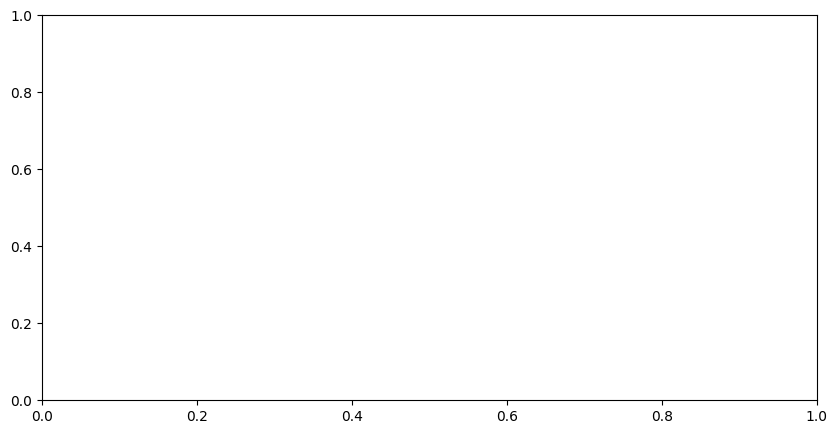

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         plotting training results
###-------------------------------------------------------------------------------------------------------------------

epochs = history["epoch"]
train_loss = history["loss"]
train_acc = history["acc"]
val_loss = history["val-loss"]
val_acc = history["val-acc"]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         test results - u-net
###-------------------------------------------------------------------------------------------------------------------
(
    test_loss_total_0,
    test_acc_total_0
) = evaluate(model, test_loader_date_0, criterion, device, config)
print("Accuracy Test Set Date 0: " + str(test_acc_total_0.item()) + "%")

(
    test_loss_total_1,
    test_acc_total_1
) = evaluate(model, test_loader_date_1, criterion, device, config)
print("Accuracy Test Set Date 1: " + str(test_acc_total_1.item()) + "%")

Accuracy Test Set Date 0: 86.81952667236328%
Accuracy Test Set Date 1: 73.85823822021484%


In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         external model from - https://arxiv.org/abs/2011.14302
###-------------------------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torch.nn import Module, Conv2d, Parameter, Softmax

from functools import partial


nonlinearity = partial(F.relu, inplace=True)


def conv3otherRelu(in_planes, out_planes, kernel_size=None, stride=None, padding=None):
    # 3x3 convolution with padding and relu
    if kernel_size is None:
        kernel_size = 3
    assert isinstance(kernel_size, (int, tuple)), 'kernel_size is not in (int, tuple)!'

    if stride is None:
        stride = 1
    assert isinstance(stride, (int, tuple)), 'stride is not in (int, tuple)!'

    if padding is None:
        padding = 1
    assert isinstance(padding, (int, tuple)), 'padding is not in (int, tuple)!'

    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
        nn.ReLU(inplace=True)  # inplace=True
    )


def l2_norm(x):
    return torch.einsum("bcn, bn->bcn", x, 1 / torch.norm(x, p=2, dim=-2))


class PAM_Module(Module):
    def __init__(self, in_places, scale=8, eps=1e-6):
        super(PAM_Module, self).__init__()
        self.gamma = Parameter(torch.zeros(1))
        self.in_places = in_places
        # self.exp_feature = exp_feature_map
        # self.tanh_feature = tanh_feature_map
        self.l2_norm = l2_norm
        self.eps = eps

        self.query_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_places, out_channels=in_places, kernel_size=1)

    def forward(self, x):
        # Apply the feature map to the queries and keys
        batch_size, chnnels, width, height = x.shape
        Q = self.query_conv(x).view(batch_size, -1, width * height)
        K = self.key_conv(x).view(batch_size, -1, width * height)
        V = self.value_conv(x).view(batch_size, -1, width * height)

        Q = self.l2_norm(Q).permute(-3, -1, -2)
        K = self.l2_norm(K)

        tailor_sum = 1 / (width * height + torch.einsum("bnc, bc->bn", Q, torch.sum(K, dim=-1) + self.eps))
        value_sum = torch.einsum("bcn->bc", V).unsqueeze(-1)
        value_sum = value_sum.expand(-1, chnnels, width * height)

        matrix = torch.einsum('bmn, bcn->bmc', K, V)
        matrix_sum = value_sum + torch.einsum("bnm, bmc->bcn", Q, matrix)

        weight_value = torch.einsum("bcn, bn->bcn", matrix_sum, tailor_sum)
        weight_value = weight_value.view(batch_size, chnnels, height, width)

        return (x + self.gamma * weight_value).contiguous()


class CAM_Module(Module):
    def __init__(self):
        super(CAM_Module, self).__init__()
        self.gamma = Parameter(torch.zeros(1))
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        batch_size, chnnels, width, height = x.shape
        proj_query = x.view(batch_size, chnnels, -1)
        proj_key = x.view(batch_size, chnnels, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy) - energy
        attention = self.softmax(energy_new)
        proj_value = x.view(batch_size, chnnels, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(batch_size, chnnels, height, width)

        out = self.gamma * out + x
        return out


class PAM_CAM_Layer(nn.Module):
    def __init__(self, in_ch):
        super(PAM_CAM_Layer, self).__init__()
        self.conv1 = conv3otherRelu(in_ch, in_ch)

        self.PAM = PAM_Module(in_ch)
        self.CAM = CAM_Module()

        self.conv2P = nn.Sequential(nn.Dropout2d(0.1, False), conv3otherRelu(in_ch, in_ch, 1, 1, 0))
        self.conv2C = nn.Sequential(nn.Dropout2d(0.1, False), conv3otherRelu(in_ch, in_ch, 1, 1, 0))

        self.conv3 = nn.Sequential(nn.Dropout2d(0.1, False), conv3otherRelu(in_ch, in_ch, 1, 1, 0))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2P(self.PAM(x)) + self.conv2C(self.CAM(x))
        return self.conv3(x)


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x


class MAResUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=5):
        super(MAResUNet, self).__init__()
        self.name = 'MAResUNet'

        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)

        #adjustment
        weight = resnet.conv1.weight.clone()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False) #here 4 indicates 4-channel input
        with torch.no_grad():
          resnet.conv1.weight[:, :3] = weight
          resnet.conv1.weight[:, 3] = resnet.conv1.weight[:, 0]

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.attention4 = PAM_CAM_Layer(filters[3])
        self.attention3 = PAM_CAM_Layer(filters[2])
        self.attention2 = PAM_CAM_Layer(filters[1])
        self.attention1 = PAM_CAM_Layer(filters[0])

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder

        x1 = self.firstconv(x)
        x1 = self.firstbn(x1)
        x1 = self.firstrelu(x1)
        x1 = self.firstmaxpool(x1)
        e1 = self.encoder1(x1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        e4 = self.attention4(e4)

        # Decoder
        d4 = self.decoder4(e4) + self.attention3(e3)
        d3 = self.decoder3(d4) + self.attention2(e2)
        d2 = self.decoder2(d3) + self.attention1(e1)
        d1 = self.decoder1(d2)

        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        # d3 = F.interpolate(d3, size=x.size()[2:], mode='bilinear', align_corners=False)

        # return torch.sigmoid(out)
        return out

In [ ]:
model_2 = MAResUNet(num_channels=4, num_classes=1).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=config["lr"])
training_loop(config["epochs"], model_2, train_loader_date_0_1_combined, valid_loader_date_0_1_combined, criterion, optimizer, device, config)

Epoch: 1/5 - loss: 0.6133 - acc: 58.50% - val-loss: 0.6196 - val-acc: 78.23% - (2.84s/epoch)
Epoch: 2/5 - loss: 0.4298 - acc: 85.97% - val-loss: 5.0565 - val-acc: 41.37% - (2.79s/epoch)
Epoch: 3/5 - loss: 0.3308 - acc: 85.88% - val-loss: 0.4113 - val-acc: 85.29% - (2.80s/epoch)
Epoch: 4/5 - loss: 0.2870 - acc: 88.59% - val-loss: 0.5402 - val-acc: 84.55% - (2.83s/epoch)
Epoch: 5/5 - loss: 0.2951 - acc: 87.97% - val-loss: 0.3847 - val-acc: 82.87% - (3.09s/epoch)
Finished Training.


{'epoch': 5,
 'loss': [0.6133261233568191,
  0.42981306165456773,
  0.3308046206831932,
  0.287029280513525,
  0.29512526392936705],
 'acc': [tensor(58.4993, device='cuda:0'),
  tensor(85.9655, device='cuda:0'),
  tensor(85.8832, device='cuda:0'),
  tensor(88.5895, device='cuda:0'),
  tensor(87.9730, device='cuda:0')],
 'val-loss': [0.6196054816246033,
  5.05654509862264,
  0.4112788240114848,
  0.5402387281258901,
  0.3847108681996663],
 'val-acc': [tensor(78.2285, device='cuda:0'),
  tensor(41.3688, device='cuda:0'),
  tensor(85.2939, device='cuda:0'),
  tensor(84.5470, device='cuda:0'),
  tensor(82.8738, device='cuda:0')]}

In [ ]:
###-------------------------------------------------------------------------------------------------------------------
#         test results - paper-model
###-------------------------------------------------------------------------------------------------------------------
(
    test_loss_total_0,
    test_acc_total_0
) = evaluate(model_2, test_loader_date_0, criterion, device, config)
print("Accuracy Test Set Date 0: " + str(test_acc_total_0.item()) + "%")

(
    test_loss_total_1,
    test_acc_total_1
) = evaluate(model_2, test_loader_date_1, criterion, device, config)
print("Accuracy Test Set Date 1: " + str(test_acc_total_1.item()) + "%")


Accuracy Test Set Date 0: 86.86280822753906%
Accuracy Test Set Date 1: 72.15550231933594%
